In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 循环神经网络

## 序列模型

先生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据，时间步为1，2，...，1000。

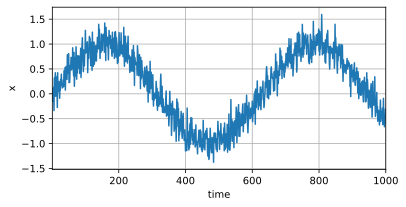

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, size=(T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，将这个序列转换为模型的“特征-标签(feature-label)”对。在这里，我们仅使用前600个“特征－标签”对进行训练。

In [ ]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

在这里，我们使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。

In [ ]:
def get_net():
    return nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1))

loss = nn.MSELoss()

In [ ]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print('epoch %d, loss: %.3f' % (epoch + 1, l.item()))

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.052
epoch 2, loss: 0.070
epoch 3, loss: 0.032
epoch 4, loss: 0.066
epoch 5, loss: 0.056


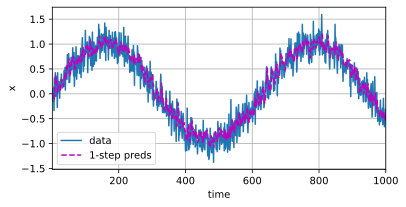

In [ ]:
# 单步预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

通常，对于直到 $𝑥_𝑡$ 的观测序列，其在时间步 𝑡+𝑘 处的预测输出 $𝑥̂_𝑡+𝑘$  称为 𝑘 步预测（ 𝑘 -step-ahead-prediction）。 由于我们的观察已经到了 $𝑥_604$ ，它的 𝑘 步预测是 $𝑥̂_{604+𝑘}$ 。 换句话说，我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。

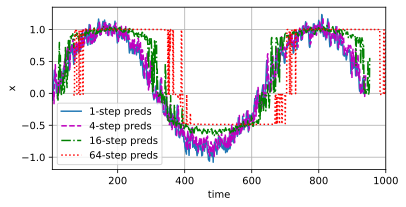

In [ ]:
# 基于k = 1, 4, 16, 64
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 `i` (`i` < `tau`) 是来自 `x` 的观测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列 `i` (`i` >= `tau`) 是 (`i - tau + 1`)步的预测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

## 文本预处理

文本的常见处理步骤，通常包括：
1. 将文本作为字符串加载到内存中。
2. 将字符串拆分为词元（如单词和字符）。
3. 建立一个词表，将拆分的词元映射到数字索引。
4. 将文本转换为数字索引序列，方便模型操作。

下面的函数将数据集读取到多条文本行组成的列表中，其中每条文本行都是一个字符串。为简单起见，我们在这里忽略了标点符号和字母大写。

In [ ]:
import collections
import re
from d2l import torch as d2l

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


下面的tokenize函数将文本行列表(lines)作为输入，列表中的每个元素是一个文本序列（如一条文本行）。每个文本序列又被拆分成一个词元列表，词元（token）是文本的基本单位。最后，返回一个由词元列表组成的列表，其中的每个词元都是一个字符串。

In [ ]:
# 词元化
def tokenize(lines, token='word'):
    """将文本行拆分成单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('error:未知词元' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [ ]:
a = [i for i in range(1, 4)]
b = [a for _ in range(3)]
# 列表生成式是可以嵌套的，相当于两个for循环的嵌套
[x for a in b for x in a]

[1, 2, 3, 1, 2, 3, 1, 2, 3]

词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。现在我们构建一个字典，通常也叫做**词表**（vocabulary），用来将字符串类型的词元映射到0开始的数字索引中。  
我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计，得到的结果叫做**语料**（corpus）。然后根据每个唯一词元的出现频率，为其分配一个数字索引。很少出现的词元通常被移除，这可以降低复杂性。  
另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“<unk>”。我们可以选择增加一个列表，用于保存那些被保留的词元，例如：填充词元<pad>、序列开始词元<bos>、序列结束词元<eos>。

In [ ]:
def count_corpus(tokens):
    """统计词元的频率"""
    # tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平使用词元填充的一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

# 词汇表
class Vocab:
    """文本词汇表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # 未知词元的索引为0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [ ]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [ ]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


将所有功能打包到load_corpus_time_machine函数中，该函数返回 corpus（词元索引列表）和 vocab（时光机器语料库的词汇表）。 
1. 为了简化后面章节中的训练，我们使用字符（而不是单词）实现文本词元化； 
2. 时光机器数据集中的每个文本行不一定是一个句子或一个段落，还可能是一个单词，因此返回的 corpus 仅处理为单个列表，而不是使用多个词元列表构成的一个列表。

In [ ]:
def load_corpus_time_machine(max_tokens=-1): 
    """返回时光机器数据集的词元索引列表和词汇表。"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## 语言模型和数据集

In [ ]:
import random
import torch
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

画出词频图，可以看到词频衰减的速度相当地快。例如，最常用的单词的词频对比，第10个还不到第一个的1/5。

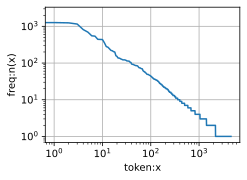

In [ ]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token:x', ylabel='freq:n(x)', xscale='log',yscale='log')

因此想要通过计数统计和平滑来建模单词是不可行的，因为这样建模的结果会大大高估尾部单词的频率，也就是所谓的不常用的单词。  
那么可以考虑其他的词元组合，比如二元语法、三元语法等。

In [ ]:
a = [i for i in range(6)]
# a, a[:-1], a[1:]
[pair for pair in zip(a[:-1], a[1:])]

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]

In [ ]:
# 看看二元语法的情况
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [ ]:
# 看看三元语法的情况
trigram_tokens = [tuple(pair) for pair in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

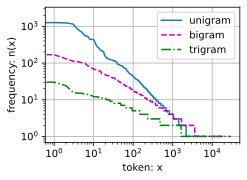

In [ ]:
# 直观比对一元语法、二元语法、三元语法三种模型中的词元频率
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

读取长序列数据

在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。 在迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻。 对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元， 因此标签是移位了一个词元的原始序列。

In [ ]:
# 随机采样
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps - 1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减1，因为需要考虑label
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

生成一个从  0  到  34  的序列。假设批量大小为  2  ，时间步数为  5 ，这意味着可以生成  ⌊(35−1)/5⌋=6  个“特征－标签”子序列对。

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY: ', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [25, 26, 27, 28, 29]]) 
Y:  tensor([[ 1,  2,  3,  4,  5],
        [26, 27, 28, 29, 30]])
X:  tensor([[15, 16, 17, 18, 19],
        [10, 11, 12, 13, 14]]) 
Y:  tensor([[16, 17, 18, 19, 20],
        [11, 12, 13, 14, 15]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]]) 
Y:  tensor([[ 6,  7,  8,  9, 10],
        [21, 22, 23, 24, 25]])


在迭代过程中，除了对原始序列可以随机抽样外， 我们还可以保证两个相邻的小批量中的子序列在原始序列上也是相邻的。 这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。

In [ ]:
# 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列。"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [ ]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


将两个采样函数包装到一个类中，将其用作数据迭代器。

In [ ]:
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [ ]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## RNN循环神经网络的实现

### 有隐状态的循环神经网络

假设我们在时间步 $𝑡$ 有小批量输入 $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ 。 换言之，对于 $𝑛$ 个序列样本的小批量，  $𝐗_𝑡$ 的每一行对应于来自该序列的时间步 $𝑡$ 处的一个样本。 接下来，用 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$  表示时间步 $𝑡$ 的隐藏变量。 与多层感知机不同的是， 我们在这里保存了前一个时间步的隐藏变量 $𝐇_{𝑡−1}$ ， 并引入了一个新的权重参数 $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ ， 来描述如何在当前时间步中使用前一个时间步的隐藏变量。 具体地说，当前时间步隐藏变量由当前时间步的输入 与前一个时间步的隐藏变量一起计算得出：

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$

从相邻时间步的隐藏变量 $𝐇_𝑡$ 和  $𝐇_{𝑡−1}$ 之间的关系可知， 这些变量捕获并保留了序列直到其当前时间步的历史信息， 就如当前时间步下神经网络的状态或记忆， 因此这样的隐藏变量被称为隐状态（hidden state）。 由于在当前时间步中， 隐状态使用的定义与前一个时间步中使用的定义相同， 因此上式的计算是循环的（recurrent）。 于是基于循环计算的隐状态神经网络被命名为 循环神经网络（recurrent neural network）。 在循环神经网络中执行上式计算的层称为循环层（recurrent layer）。

对于时间步 𝑡 ，输出层的输出类似于多层感知机中的计算：
$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

循环神经网络的参数包括隐藏层的权重  $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$,和偏置 $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$ ， 以及输出层的权重 $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$  和偏置 $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ 。 值得一提的是，即使在不同的时间步，循环神经网络也总是使用这些模型参数。 因此，循环神经网络的参数开销不会随着时间步的增加而增加。

在本例中，模型参数是 $𝐖_{𝑥ℎ}$ 和 $𝐖_{ℎℎ}$ 的拼接， 以及 $𝐛_ℎ$ 的偏置。 当前时间步 𝑡 的隐状态 $𝐇_𝑡$  将参与计算下一时间步 𝑡+1 的隐状态 $𝐇_{𝑡+1}$ 。 而且 $𝐇_𝑡$ 还将送入全连接输出层， 用于计算当前时间步 𝑡 的输出 $𝐎_𝑡$ 。

### 困惑度(Perplexity)

困惑度是用于评估语言模型质量的一个指标。困惑度的最好的理解是“下一个词元的实际选择数的调和平均数”。 我们看看一些案例：

* 在最好的情况下，模型总是完美地估计标签词元的概率为1。 在这种情况下，模型的困惑度为1。  

* 在最坏的情况下，模型总是预测标签词元的概率为0。 在这种情况下，困惑度是正无穷大。

* 在基线上，该模型的预测是词表的所有可用词元上的均匀分布。 在这种情况下，困惑度等于词表中唯一词元的数量。 事实上，如果我们在没有任何压缩的情况下存储序列， 这将是我们能做的最好的编码方式。 因此，这种方式提供了一个重要的上限， 而任何实际模型都必须超越这个上限。

### 从零实现

隐状态中$\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}$的计算， 相当于 $𝐗_𝑡$ 和 $𝐇_{𝑡−1}$ 的拼接 与 $𝐖_{𝑥ℎ}$ 和 $𝐖_{ℎℎ}$ 的拼接的矩阵乘法。

In [ ]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [ ]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape
# 时间步数，批量大小，词汇表大小

torch.Size([5, 2, 28])

初始化模型参数

In [ ]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

定义RNN模型

In [ ]:
# 初始化状态
def init_rnn_state(batch_size, num_hiddens, device):
    # 返回的状态是一个tuple
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [ ]:
# forward函数
def rnn(inputs, state, params):
    # inputs.shape: 时间步数，批量大小，词汇表大小
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X.shape: 批量大小，词汇表大小
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [ ]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.device = device
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state = init_state
        self.forward_fn = forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, self.device)

In [ ]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], device=d2l.try_gpu())
Y, new_state = net(X, state)
# Y的行数：批量大小 * 时间步数
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

预测：  
让我们首先定义预测函数来生成prefix之后的新字符，其中的prefix是一个用户提供的包含多个字符的字符串。在循环遍历prefix中的开始字符时，我们不断地将隐藏状态传递到下一个时间步，但是不生成任何输出。这被称为“预热”（warm-up）期，因为在此期间模型会自我更新（例如，更新隐藏状态），但不会进行预测。预热期结束后，隐藏状态的值通常比刚开始的初始值更适合预测，从而预测字符并输出它们。

In [ ]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:    # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for i in range(num_preds):  # 预测'num_steps'步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller <unk>mgfhsqlgf'

#### 梯度裁剪

对于长度为 𝑇 的序列，我们在迭代中计算这 𝑇 个时间步上的梯度， 将会在反向传播过程中产生长度为 O(T) 的矩阵乘法链。 当 𝑇 较大时，它可能导致数值不稳定， 例如可能导致梯度爆炸或梯度消失。 因此，循环神经网络模型往往需要额外的方式来支持稳定训练。

一个流行的替代方案是通过将梯度 𝐠 投影回给定半径 （例如 𝜃 ）的球来裁剪梯度 𝐠 。 如下式：
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$
通过这样做，我们知道梯度范数永远不会超过 𝜃 ， 并且更新后的梯度完全与 𝐠 的原始方向对齐。 它还有一个值得拥有的副作用， 即限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响， 这赋予了模型一定程度的稳定性。 梯度裁剪提供了一个**快速修复梯度爆炸**的方法， 虽然它并不能完全解决问题，但它是众多有效的技术之一。

梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

In [ ]:
# 梯度剪裁
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # l2范数
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

训练

In [ ]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化`state`
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state`对于`nn.GRU`是个张量
                state.detach_()
            else:
                # `state`对于`nn.LSTM`或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了`mean`函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [ ]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

### pytorch简洁实现

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [ ]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [ ]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [ ]:
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），`num_directions`应该是2，否则应该是1。
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将`Y`的形状改为(`时间步数`*`批量大小`, `隐藏单元数`)。
        # 它的输出形状是 (`时间步数`*`批量大小`, `词表大小`)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` 以张量作为隐藏状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # `nn.LSTM` 以张量作为隐藏状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [ ]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerwwaaaaaaaa'

perplexity 1.3, 65007.3 tokens/sec on cpu
time travellerit s against reason sciluted a than whace ton and 
traveller huthen stou anoutring ho ghas is ohe hace the eer


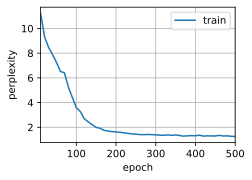

In [ ]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# 现代循环神经网络

## GRU 门控循环单元

门控循环单元与普通的循环神经网络之间的关键区别在于： 门控循环单元支持隐状态的门控。 这意味着模型有专门的机制来确定应该何时更新隐状态， 以及应该何时重置隐状态。

我们首先介绍重置门（reset gate）和更新门（update gate）。 我们把它们设计成 (0,1) 区间中的向量， 这样我们就可以进行凸组合。 重置门允许我们控制“可能还想记住”的过去状态的数量； 更新门将允许我们控制新状态中有多少个是旧状态的副本。

我们从构造这些门控开始。 下图描述了门控循环单元中的隐状态的计算流， 输入是由当前时间步的输入和前一时间步的隐状态给出。 两个门的输出是由使用sigmoid激活函数的两个全连接层给出。
<center><img src="https://zh-v2.d2l.ai/_images/gru-3.svg" /></center>

重置门和更新门的计算方式如下：
$$\begin{split}\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}\end{split}$$

由重置门机制计算得到**待选隐状态**：
$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$

由更新门机制和待选隐状态计算得到隐状态：
$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

总之，门控循环单元具有以下两个显著特征：

* 重置门有助于捕获序列中的短期依赖关系。
* 更新门有助于捕获序列中的长期依赖关系。

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = num_hiddens

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)), 
                normal((num_hiddens, num_outputs)),
                torch.zeros(num_hiddens, device=device))

    W_xr, W_hr, b_r = three()   # 更新门参数
    W_xz, W_hz, b_z = three()   # 重置门参数
    W_xh, W_hh, b_h = three()   # 候选隐藏状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [ ]:
# 定义隐状态的初始化函数
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device))

In [ ]:
# forward
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

pytorch实现

perplexity 1.0, 123400.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


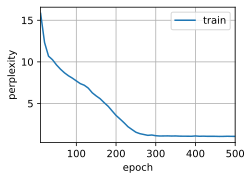

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## LSTM 长短期记忆网络

LSTM有三个门，它们由具有Sigmoid激活函数的全连接层处理，分别叫做输入门、输出门、遗忘门。这三个门的输出都在(0, 1)范围内。

* 当某个neuron的输出想要被写进memory cell，它就必须要先经过一道叫做input gate的闸门，如果input gate关闭，则任何内容都无法被写入，而关闭与否、什么时候关闭，都是由神经网络自己学习到的。
* output gate决定了外界是否可以从memory cell中读取值，当output gate关闭的时候，memory里面的内容同样无法被读取。
* forget gate则决定了什么时候需要把memory cell里存放的内容忘记清空，什么时候依旧保存。

<center><img src="https://gitee.com/Sakura-gh/ML-notes/raw/master/img/lstm.png" width=50%/></center>

t时间步的门定义如下：输入门是$I_t$，遗忘门是$F_t$，输出门是$O_t$，计算式为：
$$\begin{split}\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}\end{split}$$

**memory cell记忆元**的输出由**候选记忆元**得到。候选记忆元的激活函数为tanh，值的范围在(-1, 1)，拥有自己的参数。计算式为：
$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

在门控循环单元中，有一种机制来控制输入和遗忘（或跳过）。 类似地，在长短期记忆网络中，也有两个门用于这样的目的： 输入门 $𝐈_𝑡$ 控制采用多少来自 $𝐂̃_𝑡$ 的新数据， 而遗忘门 $𝐅_𝑡$ 控制保留多少过去的记忆元 $𝐂_{𝑡−1}$ 的内容。 使用按元素乘法，得出：
$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

最后计算隐状态：
$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆单元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [5]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [6]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

perplexity 1.1, 101878.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


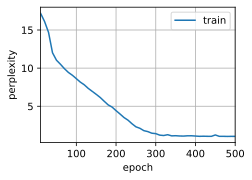

In [7]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Seq2Seq


### Encoder-Decoder架构

机器翻译是序列转换模型的一个核心问题， 其输入和输出都是长度可变的序列。 为了处理这种类型的输入和输出， 我们可以设计一个包含两个主要组件的架构： 第一个组件是一个编码器（encoder）： 它接受一个长度可变的序列作为输入， 并将其转换为具有固定形状的编码状态。 第二个组件是解码器（decoder）： 它将固定形状的编码状态映射到长度可变的序列。 这被称为编码器-解码器（encoder-decoder）架构， 如图所示。

<center><img src="https://zh-v2.d2l.ai/_images/encoder-decoder.svg" /></center>

我们以英语到法语的机器翻译为例： 给定一个英文的输入序列：“They”、“are”、“watching”、“.”。 首先，这种“编码器－解码器”架构将长度可变的输入序列编码成一个“状态”， 然后对该状态进行解码， 一个词元接着一个词元地生成翻译后的序列作为输出： “Ils”、“regordent”、“.”。 

遵循编码器－解码器架构的设计原则， 循环神经网络编码器使用长度可变的序列作为输入， 将其转换为固定形状的隐状态。 换言之，输入序列的信息被编码到循环神经网络编码器的隐状态中。 为了连续生成输出序列的词元， 独立的循环神经网络解码器是基于输入序列的编码信息 和输出序列已经看见的或者生成的词元来预测下一个词元。

<center><img src="https://zh-v2.d2l.ai/_images/seq2seq.svg" /></center>

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

### 编码器

In [14]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状 batch_size, num_steps, embed_size
        X = self.embedding(X)
        # RNN中，第一个轴对应于时间步数
        X = X.permute(1, 0, 2)  # 将维度换位
        # print('log：',X.shape)
        output, state = self.rnn(X)
        # output的形状 num_steps, batch_size, num_hiddens
        # state[0]的形状 num_layers, batch_size, num_hiddens
        return output, state

In [15]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
print(output.shape)
print(state.shape)

torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


### 解码器

In [16]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context, 使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat([X, context], dim=-1)
        # X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状 batch_size, num_steps, vocab_size
        # state[0]的形状 num_layers, batch_size, num_hiddens
        return output, state

In [34]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

### 预测序列的评估

我们可以通过与真实的标签序列进行比较来评估预测序列。 虽然提出的BLEU（bilingual evaluation understudy） 最先是用于评估机器翻译的结果， 但现在它已经被广泛用于测量许多应用的输出序列的质量。 原则上说，对于预测序列中的任意 𝑛 元语法（n-grams）， BLEU的评估都是这个 𝑛 元语法是否出现在标签序列中。

我们将BLEU定义为：
$$\exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$

其中 $len_label$ 表示标签序列中的词元数和  $len_pred$ 表示预测序列中的词元数，  𝑘 是用于匹配的最长的 𝑛 元语法。 另外，用 $𝑝_𝑛$ 表示 𝑛 元语法的精确度，它是两个数量的比值： 第一个是预测序列与标签序列中匹配的 𝑛 元语法的数量， 第二个是预测序列中 𝑛 元语法的数量的比率。 具体地说，给定标签序列 𝐴 、 𝐵 、 𝐶 、 𝐷 、 𝐸 、 𝐹  和预测序列 𝐴 、 𝐵 、 𝐵 、 𝐶 、 𝐷 ， 我们有 𝑝1=4/5 、 𝑝2=3/4 、 𝑝3=1/3 和 𝑝4=0 。

In [ ]:
def bleu(pred_seq, label_seq, k):  
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

# Attention注意力机制

[self-attention](./self-attention/)

## 注意力分数函数

### 加性注意力

In [47]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)

        self.w_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, valid_lens):
        q, k = self.w_q(q), self.w_k(k)
        print(f'q shape: {q.shape}')
        print(f'k shape: {k.shape}')
        # 在维度扩展后，
        # queries的形状：(batch_size，query_size，1，num_hidden)
        # key的形状：(batch_size，1，key_size，num_hiddens)
        # 使用广播方式进行求和
        features = q.unsqueeze(2) + k.unsqueeze(1)
        print(f'features shape: {features.shape}')
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从shape中移除最后那个维度。
        # scores的形状：(batch_size，query_size，key_size)
        scores = self.w_v(features).squeeze(-1)
        print(f'scores shape: {scores.shape}')
        # self.attention_weights = masked_softmax(scores, valid_lens)
        self.attention_weights = F.softmax(scores, dim=-1)
        print(f'self.attention_weights shape: {self.attention_weights.shape}')
        # values: (batchsize, key_size, value_size)
        return torch.bmm(self.attention_weights, v)

In [48]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

q shape: torch.Size([2, 1, 8])
k shape: torch.Size([2, 10, 8])
features shape: torch.Size([2, 1, 10, 8])
scores shape: torch.Size([2, 1, 10])
self.attention_weights shape: torch.Size([2, 1, 10])


tensor([[[18., 19., 20., 21.]],

        [[18., 19., 20., 21.]]], grad_fn=<BmmBackward0>)

#### 缩放点积注意力

In [61]:
import math

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，query_size，d)
    # keys的形状：(batch_size，key_size，d)
    # values的形状：(batch_size，key_size，value_size)
    # valid_lens的形状:(batch_size，)或者(batch_size，query_size)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        print(f'q shape: {queries.shape}')
        print(f'k shape: {keys.shape}')
        scores = torch.bmm(queries, keys.transpose(1,2))
        scores = scores / math.sqrt(d)
        print(f'scores shape: {scores.shape}')
        # self.attention_weights = d2l.masked_softmax(scores, valid_lens)
        self.attention_weights = F.softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [62]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

q shape: torch.Size([2, 1, 2])
k shape: torch.Size([2, 10, 2])
scores shape: torch.Size([2, 1, 10])


tensor([[[18., 19., 20., 21.]],

        [[18., 19., 20., 21.]]])

## MultiheadAttention

In [64]:
def transpose_qkv(X, num_heads):
    """为了多头注意力的并行计算而变换形状"""
    # X in: (batchsize, q/k size, num_hiddens)
    # X out: (batchsize, q/k size, num_heads, num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # X out: (batchsize, num_heads, q/k size, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # X final out: (batchsize*num_heads, q/k size, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv的操作"""
    X = X.reshape(-1, num_heads, X.shape[-1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [65]:
class MultiHeadAttention(nn.Module):
    def __init__(self, q_size, k_size, v_size, num_heads, num_hiddens, bias=False):
        super(MultiHeadAttention, self).__init__()

        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout=0.3)
        self.w_q = nn.Linear(q_size, num_hiddens, bias=bias)
        self.w_k = nn.Linear(k_size, num_hiddens, bias=bias)
        self.w_v = nn.Linear(v_size, num_hiddens, bias=bias)
        self.w_o = nn.Linear(v_size, num_hiddens, bias=bias)

    def forward(self, q, k, v):
        # q,k,v : (batchsize, q/k size, num_hiddens)
        # transpose: (batchsize*num_heads, q/k size, num_hiddens/num_heads)
        q = transpose_qkv(self.w_q(q), self.num_heads)
        k = transpose_qkv(self.w_k(k), self.num_heads)
        v = transpose_qkv(self.w_v(v), self.num_heads)

        output = self.attention(q, k, v)
        output_concat = transpose_output(output, self.num_heads)
        return self.w_o(output_concat)

In [66]:
num_hiddens, num_heads = 100, 5
attn = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_heads, num_hiddens)
attn.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (w_q): Linear(in_features=100, out_features=100, bias=False)
  (w_k): Linear(in_features=100, out_features=100, bias=False)
  (w_v): Linear(in_features=100, out_features=100, bias=False)
  (w_o): Linear(in_features=100, out_features=100, bias=False)
)

In [67]:
batch_size, num_queries = 2, 4
num_kvpairs =  6
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y).shape

q shape: torch.Size([2, 4, 100])
k shape: torch.Size([2, 6, 100])
scores shape: torch.Size([2, 4, 6])


torch.Size([2, 4, 100])

## Positional Encoding

In [68]:
class PositionalEncoding(nn.Module):
    """位置编码"""

    def __init__(self, num_hiddens, dropout, max_len=10000):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(dropout)
        # 足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens
        )
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :]
        return self.dropout(X)

# Transformer

## 概述

Transformer作为编码器－解码器架构的一个实例，其整体架构下图中展示。正如所见到的，transformer是由编码器和解码器组成的。transformer的编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的嵌入（embedding）表示将加上位置编码（positional encoding），再分别输入到编码器和解码器中。

<center><img src='https://zh-v2.d2l.ai/_images/transformer.svg'><center/>

上图概述了transformer的架构。从宏观角度来看，transformer的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为）。第一个子层是多头自注意力（multi-head self-attention）汇聚；第二个子层是基于位置的前馈网络（positionwise feed-forward network）。具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受 7.6节中残差网络的启发，每个子层都采用了残差连接（residual connection）。在transformer中，对于序列中任何位置的任何输入，都要求满足，以便残差连接满足。在残差连接的加法计算之后，紧接着应用层规范化（layer normalization）。因此，输入序列对应的每个位置，transformer编码器都将输出一个维表示向量。

Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为编码器－解码器注意力（encoder-decoder attention）层。在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种掩蔽（masked）注意力保留了自回归（auto-regressive）属性，确保预测仅依赖于已生成的输出词元

## 基于位置的前馈网络
基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是基于位置的（positionwise）的原因。在下面的实现中，输入X的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，ffn_num_outputs）的输出张量。

In [ ]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.rule = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.rule(self.dense(X)))

In [6]:
ffn = PositionWiseFFN(4 ,4, 8)
ffn.eval()
ffn(torch.ones(2, 3, 4)).shape

torch.Size([2, 3, 8])

## 残差连接和层规范化
开始关注与（add&norm）组件。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

BatchNorm： 对一个batch-size样本内的每个特征做归一化
LayerNorm： 针对每条样本，对每条样本的所有特征做归一化

对于2D输入来说，BatchNorm就是对每列特征做归一化，LayerNorm就是对每行做归一化。

差异：
* 如果你的特征依赖不同样本的统计参数，那BatchNorm更有效， 因为它不考虑不同特征之间的大小关系，但是保留不同样本间的大小关系
* NLP领域适合用LayerNorm， CV适合BatchNorm，
* 对于NLP来说，它不考虑不同样本间的大小关系，保留样本内不同特征之间的大小关系*

In [13]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


下面使用残差连接和层规范化实现AddNorm类。

In [17]:
class AddNorm(nn.Module):
    def __init__(self, normlized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normlized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [18]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones(2, 3, 4), torch.ones(2, 3, 4)).shape

torch.Size([2, 3, 4])

## Encoder

有了组成transformer编码器的基础组件，现在可以先实现编码器中的一个层。下面的EncoderBlock类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。

In [19]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_head, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_head, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [20]:
# transformer编码器中的任何层都不会改变其输入的形状
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_block = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_block.eval()
encoder_block(X, valid_lens).shape

torch.Size([2, 100, 24])

在实现下面的transformer编码器的代码中，我们堆叠了num_layers个EncoderBlock类的实例。由于我们使用的是值范围在-1和1之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。

In [21]:
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

指定超参数来创建一个两层的transformer编码器，输出的形状是（批量大小，时间步数，num_hiddens）

In [22]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## Decoder

transformer解码器也是由多个相同的层组成。在DecoderBlock类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于序列到序列模型（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数dec_valid_lens，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。

In [23]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [24]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 训练

In [ ]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使用transformer模型将一些英语句子翻译成法语，并计算它们的BLEU分数。

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')